In [24]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pathlib
from sklearn import preprocessing
from PIL import Image
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [12]:
def getLastConvLayer(model):
    return next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))

In [51]:
def gradCAM(name, intensity=0.5):
    
    modelNames= ["CNN_v5_fullNet-data3.h5", "CNN_v5_fullNet-data7.h5",
                 "CNN_v5_fullNet-data15.h5", "CNN_v5_fullNet.h5",
                 "CNN-TL_efficientNet-data3.h5", "CNN-TL_efficientNet-data7.h5",
                 "CNN-TL_efficientNet-data15.h5", "CNN-TL_efficientNet.h5"]
    
    stringArrData3= ["CHE","ISL","PRT"]
    stringArrData7= ["CHE","FIN","GBR","ISL","ITA","MKD","PRT"]
    stringArrData15=["AUT","BEL","CHE","DNK","EST","FIN","GBR","IRL","ISL","ITA","MKD","NOR","POL","PRT","SWE"]
    stringArr= ["AUT","BEL","BGR","CHE","CZE","DNK","ESP","EST","FIN",
                "FRA","GBR","HRV","HUN","IRL","ISL","ITA","LTU","LVA",
                "MKD","NLD","NOR","POL","PRT","SVK","SVN","SWE"]
    
    
    res=[400, 400, 400, 400, 380, 380, 380, 380]
    heatmaps = [None] * 8
    predictions= [None] * 8
    global image
    
    for i in range(len(modelNames)):
    
        model = tf.keras.models.load_model(modelNames[i])        

        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            "/home/pascal_steiger/Documents/vis/",
            target_size=(res[i], res[i]),
            batch_size=1,
            class_mode='sparse',
            shuffle=False)

        preds = model.predict(test_generator, steps=1, verbose=1)
        preds = preds.flatten()
        y_class = preds.argmax()
        if "data3" in modelNames[i]:
            predictions[i]=stringArrData3[y_class]
        elif "data7" in modelNames[i]:
            predictions[i]=stringArrData7[y_class]
        elif "data15" in modelNames[i]:
            predictions[i]=stringArrData15[y_class]
        else:
            predictions[i]=stringArr[y_class]
        
        nextEl, nextLa = test_generator.next()
        with tf.GradientTape() as tape:
            last_conv_layer = getLastConvLayer(model)
            iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
            model_out, last_conv_layer = iterate(nextEl)
            class_out = model_out[:, np.argmax(model_out[0])]
            grads = tape.gradient(class_out, last_conv_layer)
            pooled_grads = K.mean(grads, axis=(1,2,3))
            
        

        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, np.squeeze(last_conv_layer, axis=0)), axis=-1)
        heatmap = K.eval(heatmap)
        #n, bins, patches = plt.hist(heatmap)
        #plt.show()
        #print("Max: "+str(np.max(heatmap)))
        #print("Min: "+str(np.min(heatmap)))
        heatmap = (heatmap - np.min(heatmap))/np.ptp(heatmap)
        #print("Max after: "+str(np.max(heatmap)))
        #print("Min after: "+str(np.min(heatmap)))
        #heatmap = np.maximum(heatmap, 0)
        #heatmap /= np.max(heatmap)
        #heatmap = heatmap.reshape((10, 10))
        
        n, bins, patches = plt.hist(heatmap)
        plt.show()
        
 

        nextEl = np.squeeze(nextEl, axis=0)

        heatmap = cv2.resize(heatmap, (nextEl.shape[0], nextEl.shape[1]))
        heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_COOL)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        img = cv2.addWeighted(heatmap, 0.6, (nextEl*255).astype(np.uint8), 0.4, 0)
        orig= Image.fromarray((nextEl*255).astype(np.uint8))
        heatmaps[i] = img
        
        if i==0:
            image = orig
    
    
    f, axarr = plt.subplots(2,5)
    axarr[0,0].imshow(image)
    axarr[1,0].imshow(image)
    for i in range(4):
        axarr[0,1+i].imshow(heatmaps[i])
        axarr[1,1+i].imshow(heatmaps[4+i])
    
    plt.tight_layout()
    plt.savefig(name+".jpg", dpi=300)
    
        
    print(predictions)
        
   



In [4]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr

In [5]:
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
labelStringArr = sorted(labelStringArr)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 1s 817ms/step


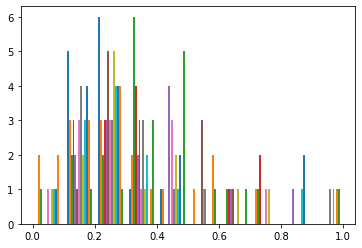

Found 1 images belonging to 1 classes.
1/1 [==============================] - 1s 613ms/step


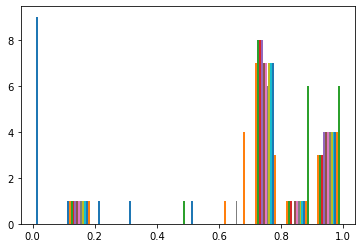

Found 1 images belonging to 1 classes.
1/1 [==============================] - 1s 504ms/step


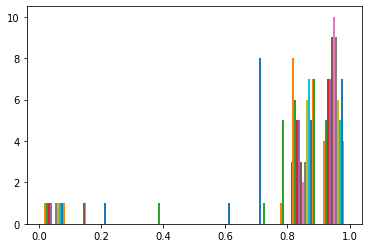

Found 1 images belonging to 1 classes.
1/1 [==============================] - 1s 508ms/step


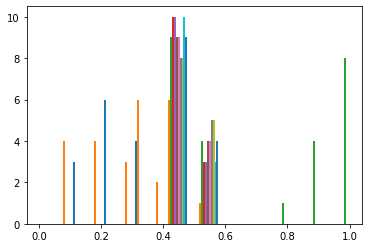

Found 1 images belonging to 1 classes.
1/1 [==============================] - 3s 3s/step


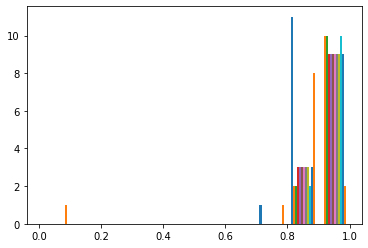

Found 1 images belonging to 1 classes.
1/1 [==============================] - 3s 3s/step


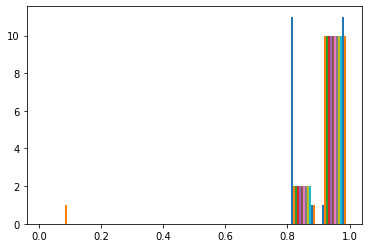

Found 1 images belonging to 1 classes.
1/1 [==============================] - 2s 2s/step


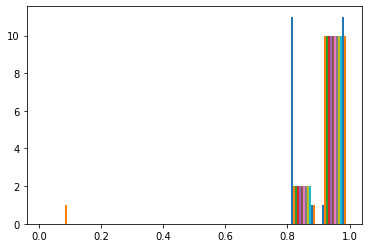

Found 1 images belonging to 1 classes.
1/1 [==============================] - 2s 2s/step


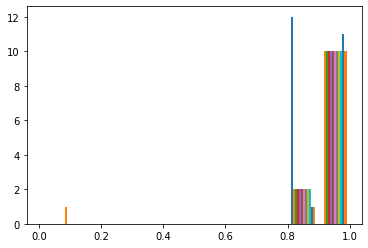

['ISL', 'ISL', 'ISL', 'ISL', 'ISL', 'ISL', 'DNK', 'NOR']


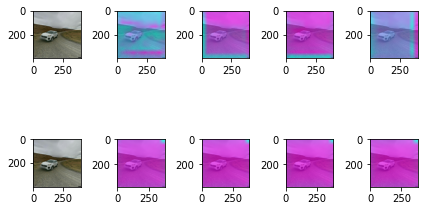

In [52]:
gradCAM("test6")